In [1]:
from typing import Union
import math

from collections import defaultdict
from itertools import combinations
import json

import numpy as np
import cv2 as cv

from skimage.transform import rescale
from skimage.measure import label, find_contours
from skimage.filters import gaussian
from scipy.spatial.distance import cdist
from skimage.feature import match_template
import scipy.stats as st

import matplotlib.pyplot as plt


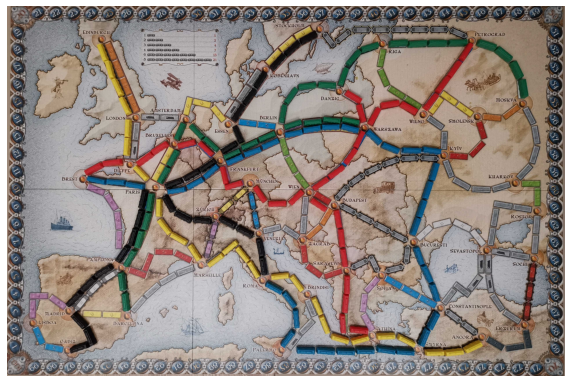

In [2]:
def plot_img(img, cmap='gray'):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()


def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

def rotate_img( img, angle, scale=1 ):
    img_ = img.copy()
    
    height, width = img_.shape[:2]
    img_center = (width/2, height/2)
    
    rotate_matrix = cv.getRotationMatrix2D(center=img_center, angle=angle, scale=1)
    return cv.warpAffine(src=img_, M=rotate_matrix, dsize=(width, height))
img = cv.imread('train/all.jpg')
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

TRAIN_CASES = {i: fname for i, fname in enumerate(('all', 'black_blue_green', 'black_red_yellow',
                                                   'red_green_blue_inaccurate', 'red_green_blue'))}

img_black_blue_green = cv.imread('train/black_blue_green.jpg')
img_black_blue_green_rgb = cv.cvtColor(img_black_blue_green, cv.COLOR_BGR2RGB)
img_black_red_yellow = cv.imread('train/black_red_yellow.jpg')
img_black_red_yellow_rgb = cv.cvtColor(img_black_red_yellow, cv.COLOR_BGR2RGB)
img_red_green_blue = cv.imread('train/red_green_blue.jpg')
img_red_green_blue_rgb = cv.cvtColor(img_red_green_blue, cv.COLOR_BGR2RGB)
img_red_green_blue_inaccurate = cv.imread('train/red_green_blue_inaccurate.jpg')
img_red_green_blue_inaccurate_rgb = cv.cvtColor(img_red_green_blue_inaccurate, cv.COLOR_BGR2RGB)

ALL_IMAGES = [cv.imread(f'train/{fname}.jpg') for fname in TRAIN_CASES.values()]
ALL_IMAGES_RGB = [cv.cvtColor(img, cv.COLOR_BGR2RGB) for img in ALL_IMAGES]
ALL_IMAGES_GRAY = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in ALL_IMAGES ]

plot_img(img_rgb)
blue_template = img_rgb[2365:2395, 1995:2125]
blue_template2 = img_rgb[2100:2220, 1970:2015]
CITY_TEMPL = img_rgb[201:255, 627:680]
CITY_TEMPL_GRAY = cv.cvtColor(CITY_TEMPL, cv.COLOR_BGR2GRAY)

# coordinate in (row, column)
approx_centers = load_json('train/all_centers.json')

# Find trains

## Blue trains

In [ ]:
def find_blue_trains_mask( img_bgr ):

    img = img_bgr.copy()
    roi_win = 70
    k_size = 3
    kernel = np.ones((k_size, k_size))
    min_area = 1000
    min_len = 100
    lower_bound = (90, 159, 90)
    upper_bound = (112, 255, 180)
    # 1 hsv filter
    HSV = cv.cvtColor( img, cv.COLOR_BGR2HSV)
    mask = cv.inRange( HSV, lower_bound, upper_bound).astype(np.uint8)
    # 2 erosion etc
    mask = cv.morphologyEx( mask, cv.MORPH_ERODE, kernel)
    # 3 find contours -> oriented rectangles
    contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # 4 filters areas and dims
    filtered_contours = []
    trains_mask = np.zeros_like(mask, dtype=np.uint8)
    # Maybe I shoud firstly remove holes
    labelled, nlabels = label(mask, connectivity=2, return_num=True)
    train_centers = []
    for cnt in contours:
        hull = cv.convexHull(cnt)
        area = cv.contourArea(hull)
        if area < min_area:
            continue
        rect = cv.minAreaRect(hull)
        center, dims, angle = rect
        center = (int(center[0]), int(center[1]))
        if max(dims) < min_len:
            continue
        label_id = labelled[center[1], center[0]]
        if label_id != 0:
            train_mask = labelled == label_id
            trains_mask = np.logical_or(trains_mask, train_mask )
    
    trains_mask = 255 * trains_mask.astype(np.uint8)
    print(trains_mask.min(), trains_mask.max())
    erode_ksize=3
    erode_kernel=np.ones((erode_ksize,erode_ksize))
    sticked_trains_mask = cv.morphologyEx(trains_mask, cv.MORPH_DILATE, erode_kernel, iterations=10)
    # sticked_trains_label = label(sticked_trains_mask, connectivity=2, return_num=True)
    

    # 5 create roi for each possible train and rotate template
        # roi = img[center[1]-roi_win:center[1]-roi_win, center[0]-roi_win:center[0]+roi_win].copy()
        # blue_rotated = cv.imread('images/blue_rotated.jpg')
        # height, width = blue_rotated.shape[:2]
        # center = (width/2, height/2)
        # rotate_matrix = cv.getRotationMatrix2D(center=center, angle=35, scale=1)
        # rotated_image = cv.warpAffine(src=blue_rotated, M=rotate_matrix, dsize=(width, height))

        # plot_img(rotated_image)
        # plot_img(blue_rotated)

        # filtered_contours.append(hull)

    # return filtered_contours
    return train_centers, sticked_trains_mask

def count_color_trains( mask, single_area=500 ):
    # TODO
    pass
    contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    count = 0
    for cnt in contours:
        area = cv.contourArea(cnt)
        
    

def count_color_trains_and_score(mask, single_area=500):
    max_train_len = 8
    max_train_area = single_area*max_train_len
    scores = []
    contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    areas = [cv.contourArea(cnt) for cnt in contours]
    # score
    n_trains = 0
    score = 0
    for cnt in contours:
        area = cv.contourArea(cnt)
        count = area/single_area
        if count < 1.5:
            n_train += 1
            score += 1
        elif 1.5 <= count < 2.5:
            n_train += 2
            score += 2
        elif 2.5 <= count < 3.5:
            n_train += 3
            score += 4
        elif 3.5 <= count < 4.5:
            n_train += 4
            score += 7
        elif 4.5 <= count < 7:
            n_train += 6
            score += 15
        else:
            n_train += 8
            score += 21
    return n_trains, score

In [ ]:
train_centers, sticked_trains_mask = find_blue_trains_mask(ALL_IMAGES[0])

0 255


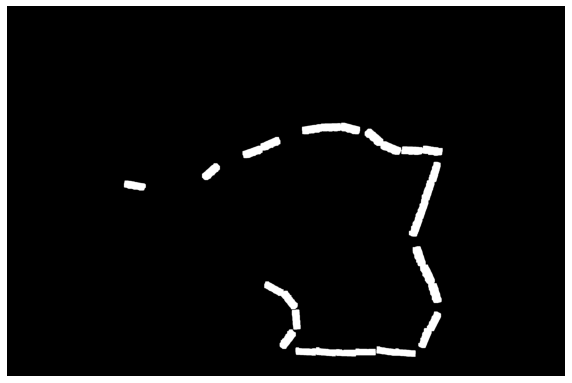

In [ ]:
plot_img(sticked_trains_mask)

In [ ]:
blue_cnts = find_blue_trains(ALL_IMAGES[0])

NameError: name 'find_blue_trains' is not defined

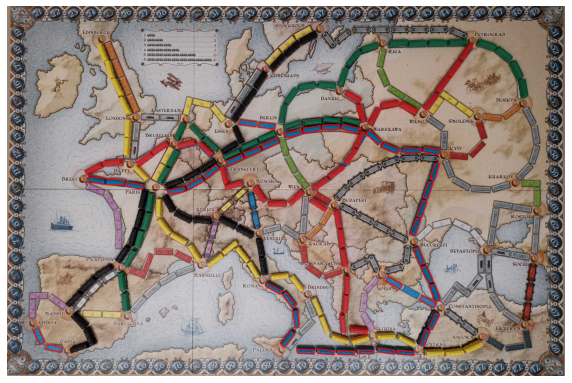

In [ ]:
blue_det_img = ALL_IMAGES_RGB[0].copy()
cv.drawContours( blue_det_img, blue_cnts, -1, color=(255,0,0), thickness=5)

plot_img(blue_det_img)

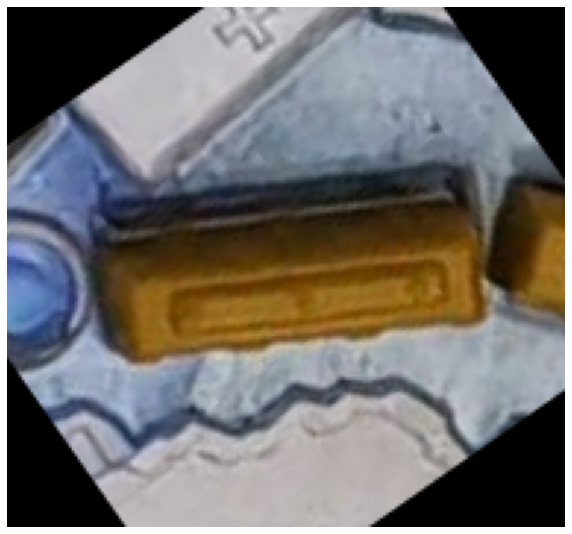

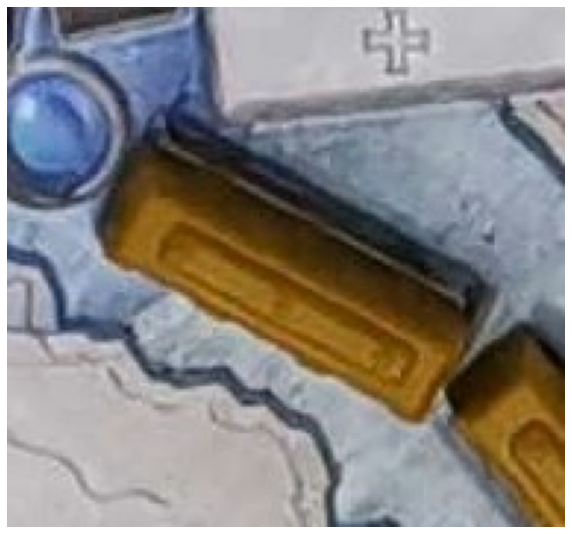

In [ ]:
blue_rotated = cv.imread('images/blue_rotated.jpg')

height, width = blue_rotated.shape[:2]
center = (width/2, height/2)
rotate_matrix = cv.getRotationMatrix2D(center=center, angle=35, scale=1)
rotated_image = cv.warpAffine(src=blue_rotated, M=rotate_matrix, dsize=(width, height))

plot_img(rotated_image)
plot_img(blue_rotated)

In [ ]:
aaa = np.zeros((3,3))
print(np.where(aaa == 0.0))

(array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 1, 2, 0, 1, 2, 0, 1, 2]))


## Retreive all train colors teamplates

### Red

True

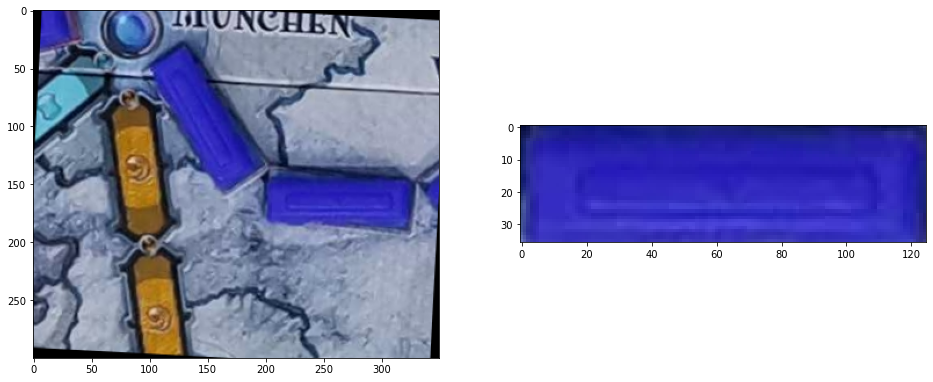

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,9))

img = cv.imread('train/all.jpg')
red_template = img[1200:1500, 1600:1950].copy()
red_template = rotate_img(red_template, -3)
ax[0].imshow(red_template);
red_template = red_template[145:181,200:325]
ax[1].imshow(red_template);
cv.imwrite('images/red_template.jpg', red_template)

True

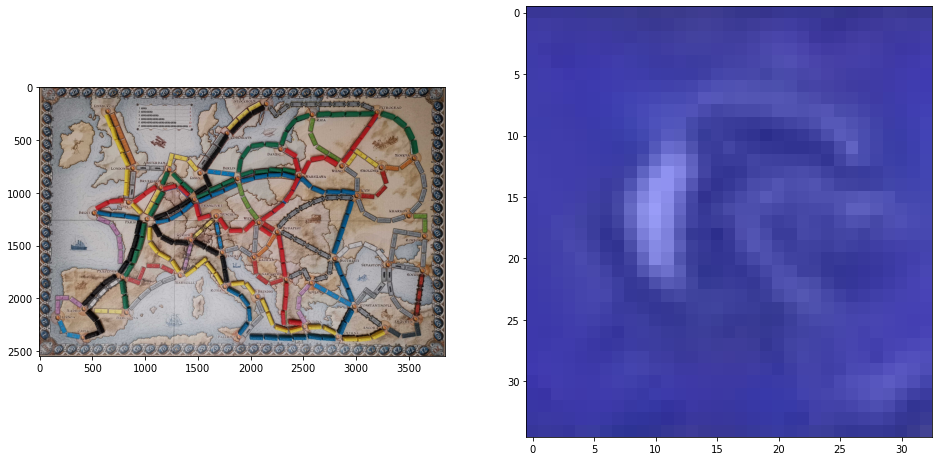

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,9))

img = cv.imread('train/all.jpg')
red_template = img[1700:1900, 2000:2300].copy()
red_template = rotate_img(red_template, 36)
ax[0].imshow(img_rgb);
red_template = red_template[120:155,117:150]
ax[1].imshow(red_template);
# cv.imwrite('images/red_label_template.jpg', red_template)

### Green

True

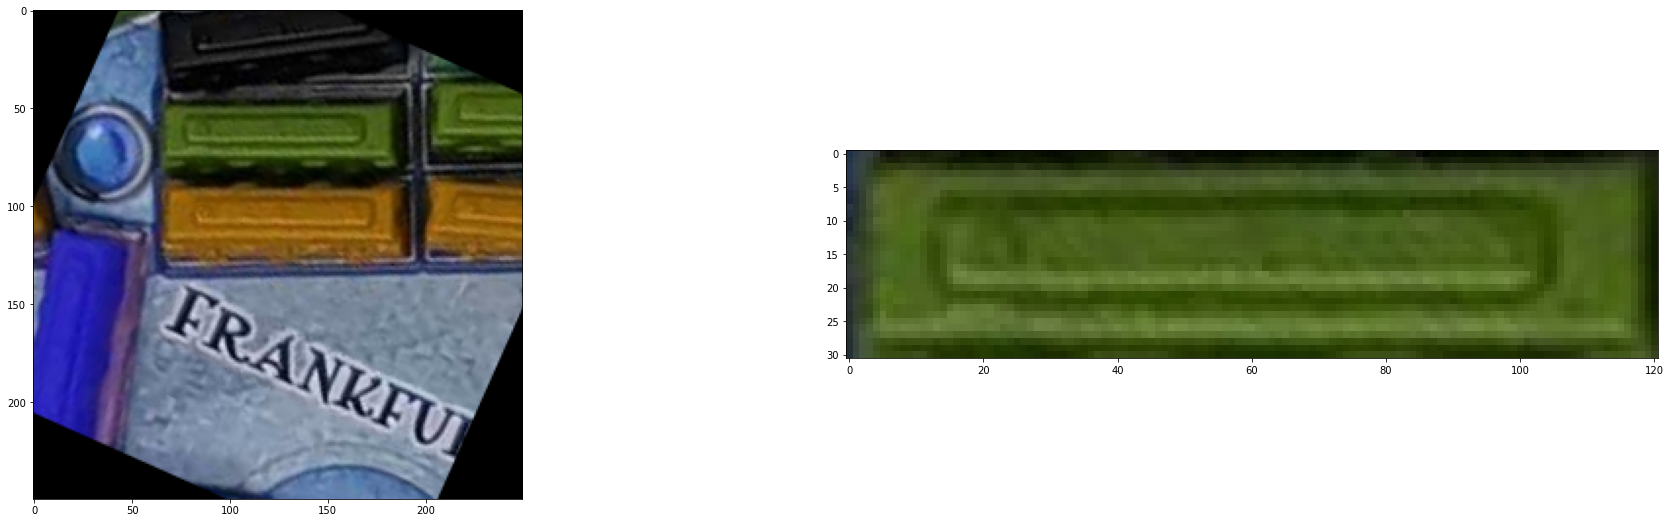

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(32,9))

img = cv.imread('train/all.jpg')
green_template = img[950:1200, 1450:1700].copy()
green_template = rotate_img(green_template, -24)
# ax[0].imshow(img_rgb);
ax[0].imshow(green_template);
green_template = green_template[47:78,64:185]
ax[1].imshow(green_template);
# cv.imwrite('images/green_template.jpg', green_template)

True

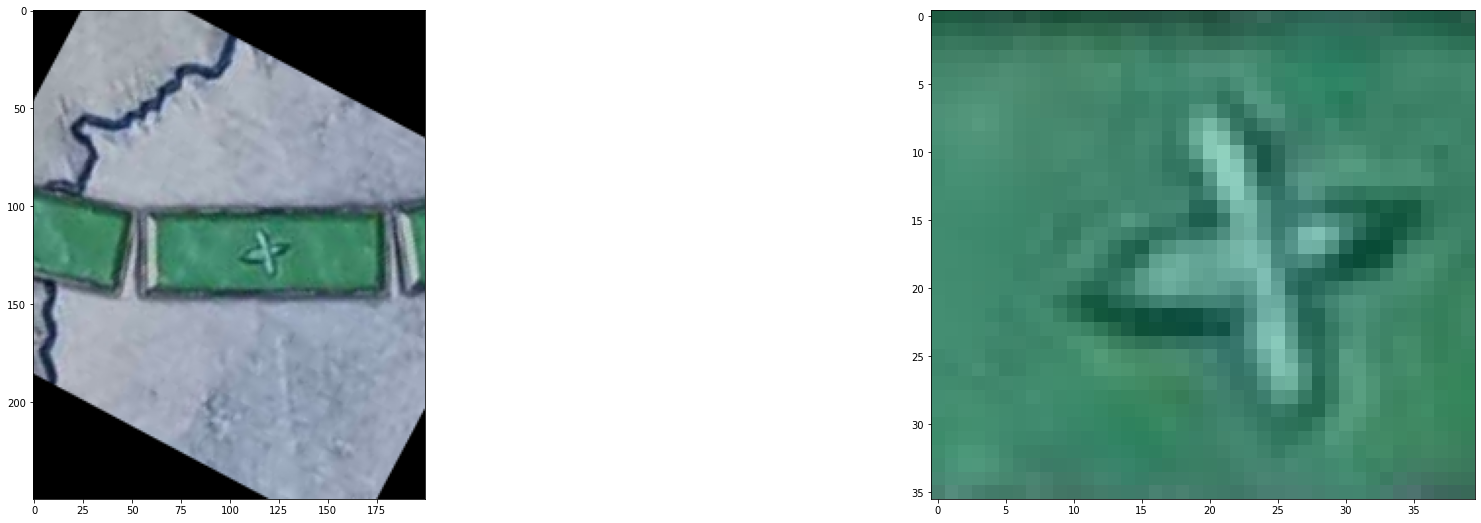

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(32,9))

img = cv.imread('train/all.jpg')
green_template = img[950:1200, 1850:2050].copy()
green_template = rotate_img(green_template, 62)
# ax[0].imshow(img_rgb);
ax[0].imshow(green_template);
green_template = green_template[106:142,95:135]
ax[1].imshow(green_template);
# cv.imwrite('images/green_label_template.jpg', green_template)

### Black

True

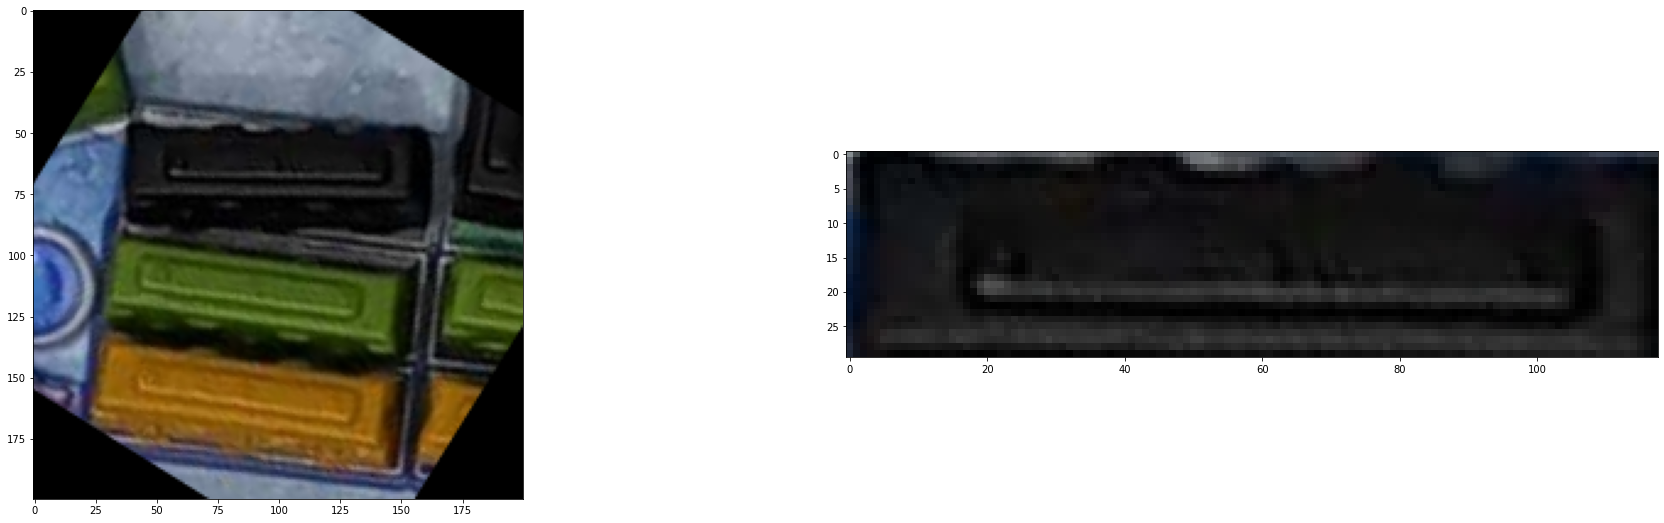

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(32,9))

img = cv.imread('train/all.jpg')
black_template = img[900:1100, 1450:1650].copy()
black_template = rotate_img(black_template, -32)
# ax[0].imshow(img_rgb);
ax[0].imshow(black_template);
black_template = black_template[47:77,37:155]
ax[1].imshow(black_template);
cv.imwrite('images/black_template.jpg', black_template)

True

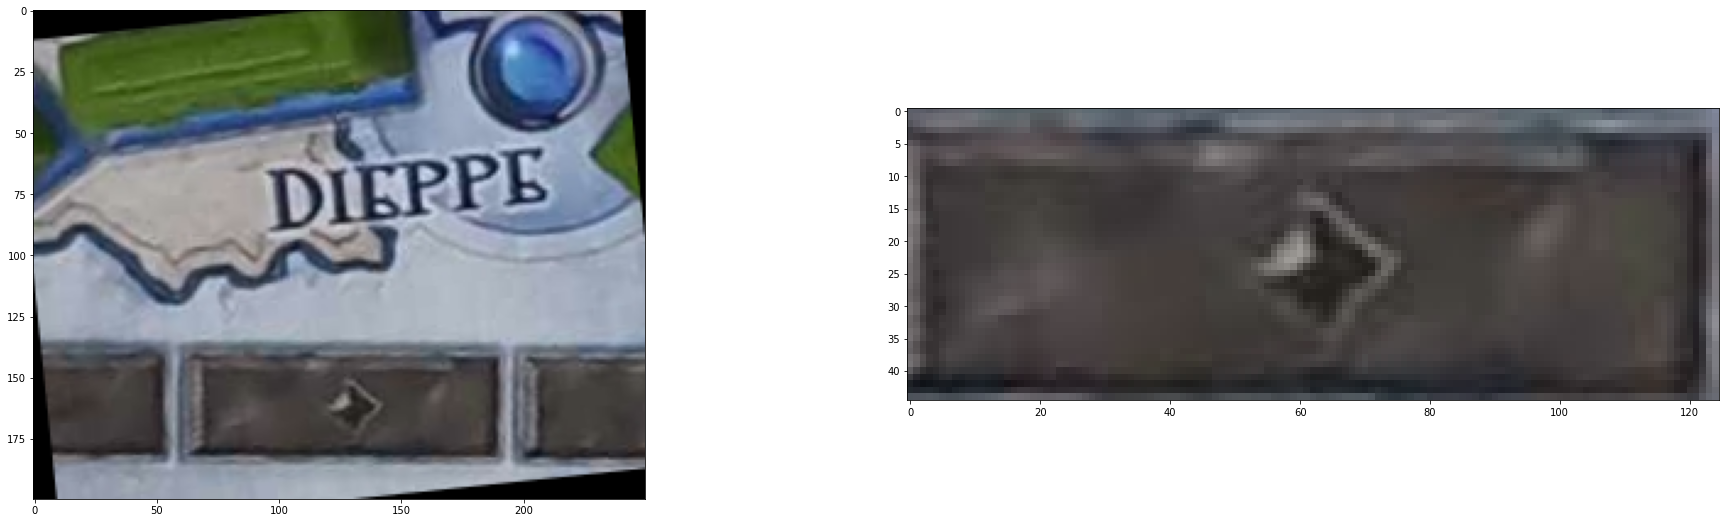

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(32,9))

img = cv.imread('train/black_blue_green.jpg')
black_template = img[1100:1300, 650:900].copy()
black_template = rotate_img(black_template, 6)
# ax[0].imshow(img_rgb);
ax[0].imshow(black_template);
black_template = black_template[138:183,67:192]
ax[1].imshow(black_template);
# cv.imwrite('images/black_template.jpg', black_template)

True

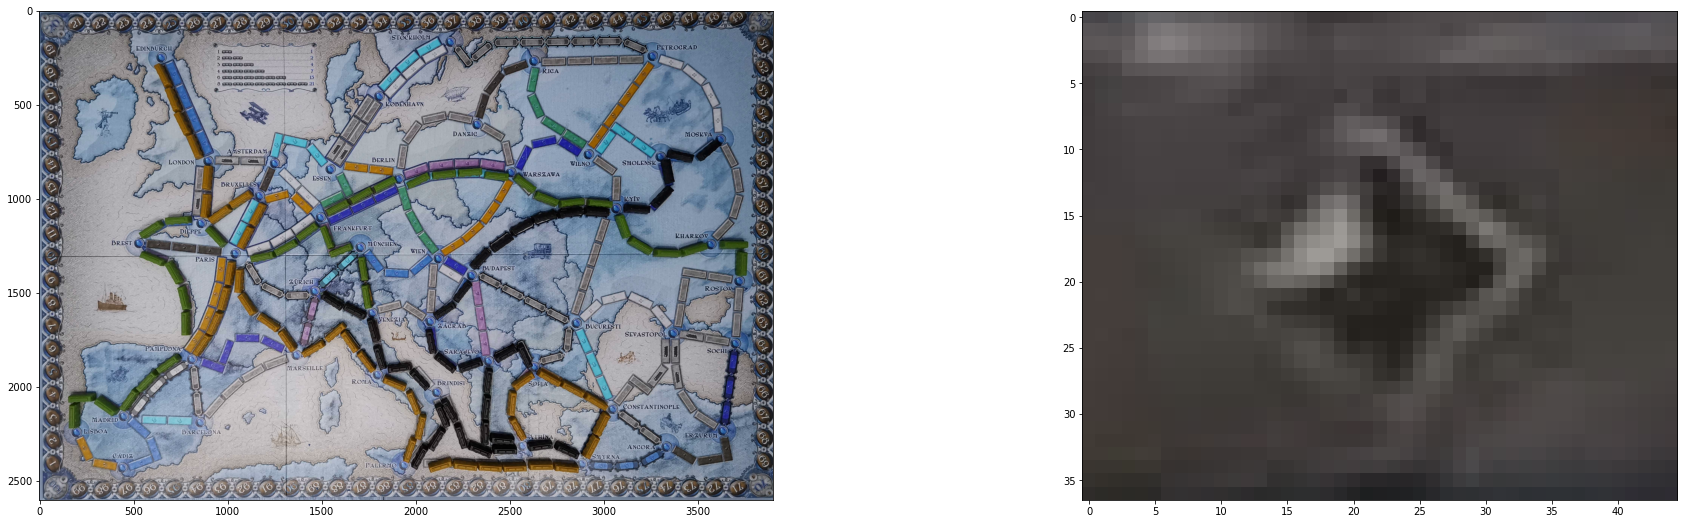

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(32,9))

img = cv.imread('train/black_blue_green.jpg')
black_template = img[1100:1300, 650:900].copy()
black_template = rotate_img(black_template, 6)
ax[0].imshow(img);
# ax[0].imshow(black_template);
black_template = black_template[143:180,108:153]
ax[1].imshow(black_template);
# cv.imwrite('images/black_label_template.jpg', black_template)

In [ ]:
print([img.shape for img in ALL_IMAGES])

[(2546, 3846, 3), (2602, 3899, 3), (2714, 3959, 3), (2653, 3938, 3), (2600, 3889, 3)]


### Yellow

True

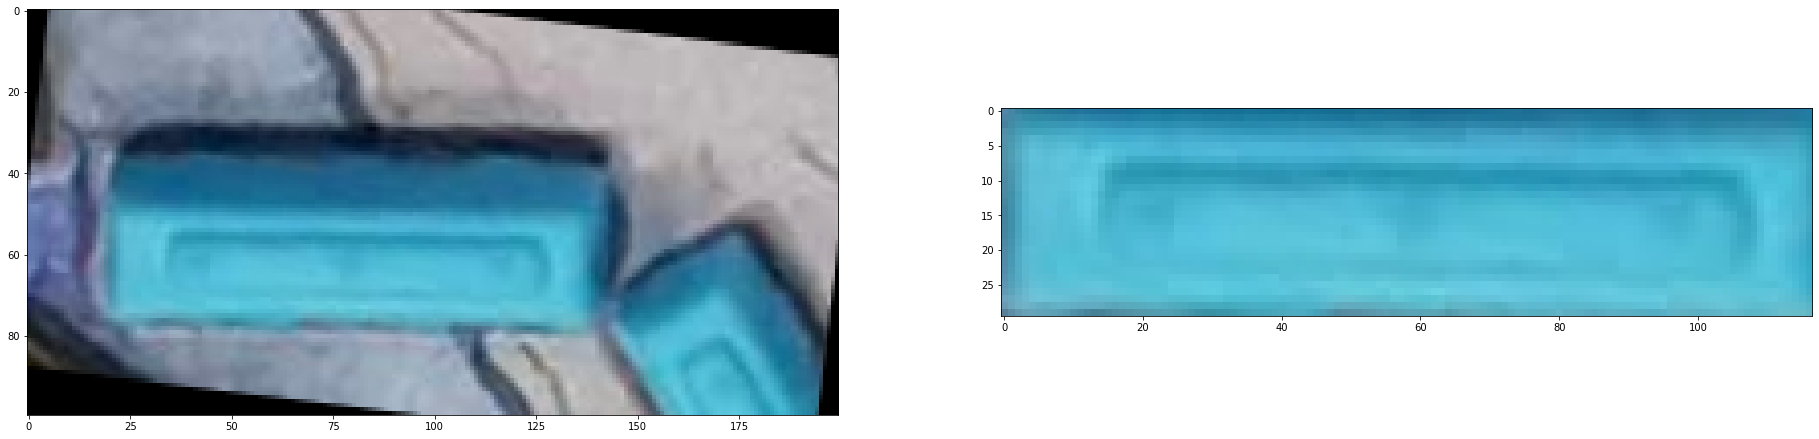

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(32,9))

img = cv.imread('train/all.jpg')
yellow_template = img[1800:1900, 1800:2000].copy()
yellow_template = rotate_img(yellow_template, -7)
# ax[0].imshow(img_rgb);
ax[0].imshow(yellow_template);
yellow_template = yellow_template[47:77,20:137]
ax[1].imshow(yellow_template);
cv.imwrite('images/yellow_template.jpg', yellow_template)

True

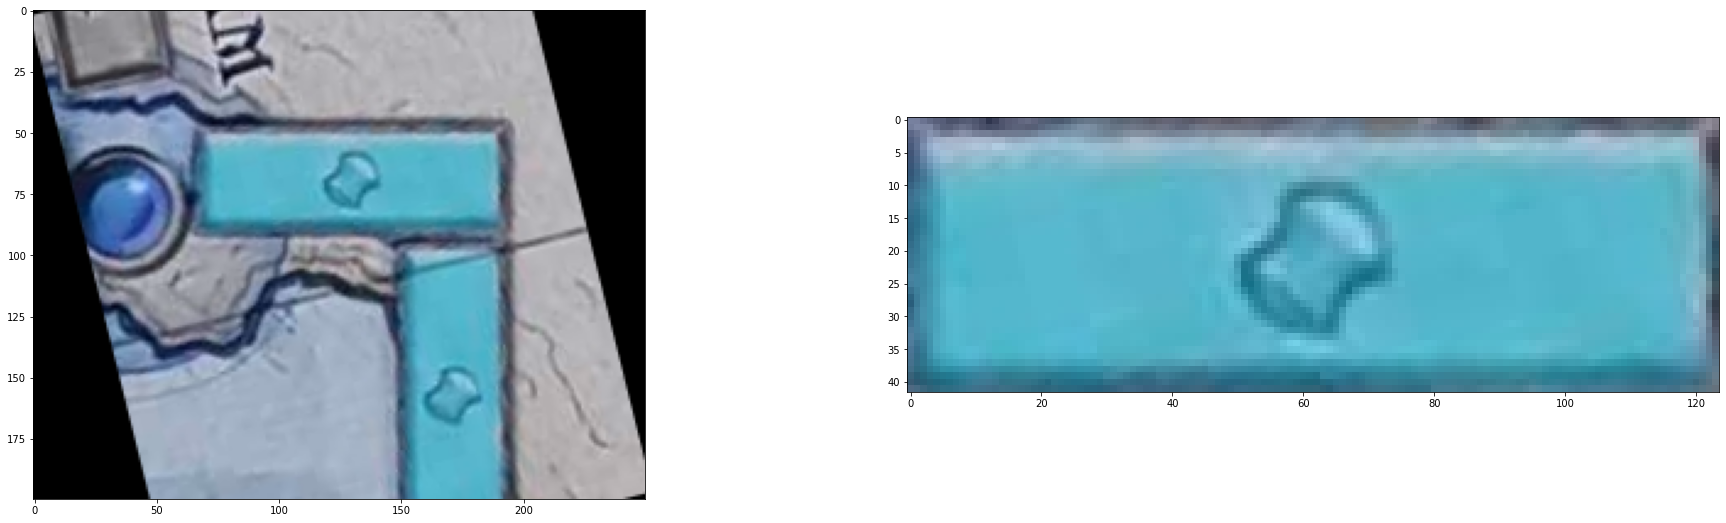

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(32,9))

img = cv.imread('train/all.jpg')
yellow_template = img[600:800, 1150:1400].copy()
yellow_template = rotate_img(yellow_template, -76)
# ax[0].imshow(img_rgb);
ax[0].imshow(yellow_template);
yellow_template = yellow_template[48:90,68:192]
ax[1].imshow(yellow_template);
# cv.imwrite('images/yellow_template.jpg', yellow_template)

True

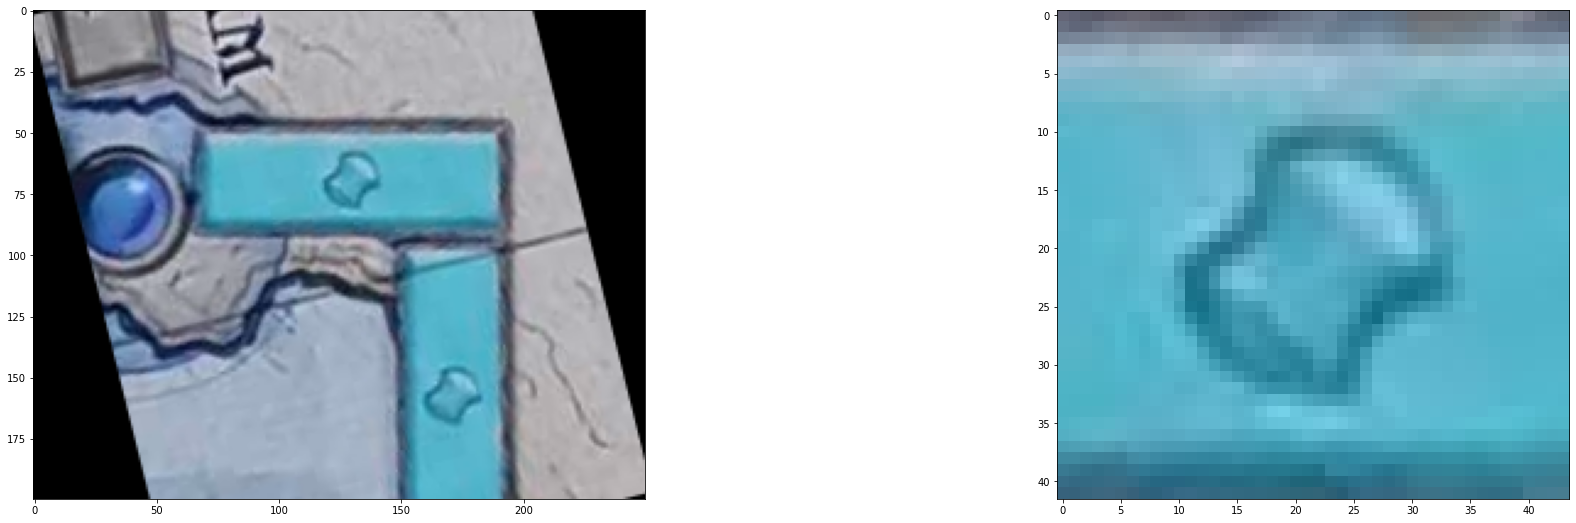

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(32,9))

img = cv.imread('train/all.jpg')
yellow_template = img[600:800, 1150:1400].copy()
yellow_template = rotate_img(yellow_template, -76)
# ax[0].imshow(img_rgb);
ax[0].imshow(yellow_template);
yellow_template = yellow_template[48:90,108:152]
ax[1].imshow(yellow_template);
cv.imwrite('images/yellow_label_template.jpg', yellow_template)